In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm
import numba as nb
import inspect

from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

@nb.njit()
def to_euler(x, y, z, w):
    """Dari Coursera: Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])
# Compile the to_euler
_ = to_euler(1.5352300785980803e-15, -1.3393747145983517e-15, -0.7692164172827881, 0.638988343698562)

In [3]:
def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

# Import Data from a Bag File

In [4]:
class get_data_from_bag(object):
    def __init__(self, path):
        self.bag = rosbag.Bag(path)
        self.cs = self._read_msg_from_topic('/control_signal', ['t', 'action_throttle', 'action_steer',
                                                                'error_lateral', 'error_yaw','error_speed',
                                                                'actual_x','actual_y','actual_yaw','actual_speed',
                                                                'ref_x', 'ref_y', 'ref_yaw', 'ref_curvature', 'ref_speed',
                                                                'wp_idx'])
        self.ar = self._read_msg_from_topic('/logging_arduino', ['t', 'steering_setpoint', 'steering_angle', 'throttle_voltage'])
        
    def _read_msg_from_topic(self, topic, columns_name):
        data = []
        for _, msg, _ in self.bag.read_messages(topics=[topic]):
            temp = []
            for name in columns_name:
                if name == 't':
                    temp.append(msg.header.stamp.to_sec())
                else:
                    nm = 'msg.' + name
                    temp.append(eval(nm))
            data.append(temp)
        return pd.DataFrame(data, columns = columns_name)

In [5]:
sl1 = get_data_from_bag('Stanley With Throttle/LURUS_1.bag')
sl2 = get_data_from_bag('Stanley With Throttle/LURUS_2.bag')
sl3 = get_data_from_bag('Stanley With Throttle/LURUS_ERROR_BESAR.bag')
ss1 = get_data_from_bag('Stanley With Throttle/S_1.bag')
ss2 = get_data_from_bag('Stanley With Throttle/S_2.bag')
sb1 = get_data_from_bag('Stanley With Throttle/BELOK_1.bag')
sb2 = get_data_from_bag('Stanley With Throttle/BELOK_2.bag')

In [6]:
pl1 = get_data_from_bag('PID With Throttle/LURUS_1.bag')
pl2 = get_data_from_bag('PID With Throttle/LURUS_2.bag')
pl3 = get_data_from_bag('PID With Throttle/LURUS_3.bag')
pl4 = get_data_from_bag('PID With Throttle/LURUS_4.bag')
ps1 = get_data_from_bag('PID With Throttle/S_1.bag')
ps2 = get_data_from_bag('PID With Throttle/S_2.bag')
ps3 = get_data_from_bag('PID With Throttle/S_3.bag')
pb1 = get_data_from_bag('PID With Throttle/BELOK_1.bag')
pb2 = get_data_from_bag('PID With Throttle/BELOK_2.bag')

# RMSE

In [7]:
def rms(x):
    return np.sqrt(np.mean(np.square(x)))

def get_rmse(obj):
    e_lat = obj.cs.error_lateral.values
    e_yaw = obj.cs.error_yaw.values
    print(str(retrieve_name(obj)))
    print('Lat: {} m'.format(rms(e_lat)))
    print('Yaw: {} deg'.format(rms(e_yaw*180/np.pi)))

In [8]:
get_rmse(sl1)
get_rmse(sl2)
get_rmse(sl3) # Tidak stabil !
get_rmse(pl1) # Terindikasi ada Noise yang cukup besar
get_rmse(pl2)
get_rmse(pl3) # Error awal besar
get_rmse(pl4) # Error awal besar

sl1
Lat: 0.1350188739186844 m
Yaw: 5.310925633873159 deg
sl2
Lat: 0.15142440269837082 m
Yaw: 4.846110147937766 deg
sl3
Lat: 1.4142906713219017 m
Yaw: 33.51925950968413 deg
pl1
Lat: 0.2300525150019683 m
Yaw: 7.201770795176448 deg
pl2
Lat: 0.12153121657747953 m
Yaw: 6.670424904270687 deg
pl3
Lat: 0.9898599055442312 m
Yaw: 22.812553276025483 deg
pl4
Lat: 1.2554530738780205 m
Yaw: 27.607109557240356 deg


In [9]:
get_rmse(ss1)
get_rmse(ss2)
get_rmse(ps1)
get_rmse(ps2)
get_rmse(ps3) # ERROR AWAL BESAR

ss1
Lat: 0.1400300368158503 m
Yaw: 5.851170045184411 deg
ss2
Lat: 0.21772308924364786 m
Yaw: 7.387460502914709 deg
ps1
Lat: 0.21792097804268684 m
Yaw: 5.3430572056157954 deg
ps2
Lat: 0.18322077444373844 m
Yaw: 5.174407781058063 deg
ps3
Lat: 0.9607089047300964 m
Yaw: 18.81070703914388 deg


In [10]:
get_rmse(sb1)
get_rmse(sb2)
get_rmse(pb1)
get_rmse(pb2)

sb1
Lat: 0.37021856309760925 m
Yaw: 11.37843787998903 deg
sb2
Lat: 0.36628019991268274 m
Yaw: 10.189688649405767 deg
pb1
Lat: 0.36005031925564773 m
Yaw: 10.65546895863722 deg
pb2
Lat: 0.34176418740163417 m
Yaw: 12.566313326497154 deg


# PLOT

## Error Awal Kecil

### Function

In [11]:
def plot_posisi(o1, o2, fig_name):
    srx = o1.cs.ref_x
    sry = o1.cs.ref_y
    sx = o1.cs.actual_x
    sy = o1.cs.actual_y
    prx = o2.cs.ref_x
    pry = o2.cs.ref_y
    px = o2.cs.actual_x
    py = o2.cs.actual_y

    a = np.min(np.array([srx, sry]).T, axis=0)
    b = np.min(np.array([sx, sy]).T, axis=0)
    c = np.min(np.array([px, py]).T, axis=0)
    d = np.min(np.array([prx, pry]).T, axis=0)
    min_val = np.min(np.array([a,b,c,d]), axis=0)

    a = np.max(np.array([srx, sry]).T, axis=0)
    b = np.max(np.array([sx, sy]).T, axis=0)
    c = np.max(np.array([px, py]).T, axis=0)
    d = np.max(np.array([prx, pry]).T, axis=0)
    max_val = np.max(np.array([a,b,c,d]), axis=0)

    center = (max_val + min_val) / 2
    scale = max_val - min_val
    max_scale = np.max(scale)

    lim_min = center - max_scale/1.9
    lim_max = center + max_scale/1.9

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.plot(srx, sry, label='Referensi', linewidth=3., color='tab:orange')
    ax1.plot(sx, sy, label='Aktual', linestyle='--', linewidth=1.5, color='black')
    ax1.set_xlim(lim_min[0], lim_max[0])
    ax1.set_ylim(lim_min[1], lim_max[1])
    ax1.set_xlabel("X (m)")
    ax1.set_ylabel("Y (m)")
    ax1.legend()
    ax1.set_title('Pengontrol Stanley')

    ax2.plot(prx, pry, label='Referensi', linewidth=3., color='tab:orange')
    ax2.plot(px, py, label='Aktual', linestyle='--', linewidth=1.5, color='black')
    ax2.set_xlim(lim_min[0], lim_max[0])
    ax2.set_ylim(lim_min[1], lim_max[1])
    ax2.set_xlabel("X (m)")
    ax2.legend()
    ax2.set_title('Pengontrol PID')

    fig.savefig('img/'+fig_name+'.png', dpi=600, transparent=True)
    plt.show()
    
def plot_e_lat(o1, o2, fig_name, lim):
    plt.plot(o1.cs.t - o1.cs.t[0], o1.cs.error_lateral, label='Pengontrol Stanley')
    plt.plot(o2.cs.t - o2.cs.t[0], o2.cs.error_lateral, label='Pengontrol PID')
    plt.xlabel("Waktu (s)")
    plt.ylabel("Galat Lateral (m)")
    plt.legend()
    plt.ylim(min(lim), max(lim))
    plt.savefig('img/'+fig_name+'.png', dpi=600, transparent=True)
    plt.show()
    
def plot_e_yaw(o1, o2, fig_name, lim):
    plt.plot(o1.cs.t - o1.cs.t[0], o1.cs.error_yaw*180./np.pi, label='Pengontrol Stanley')
    plt.plot(o2.cs.t - o2.cs.t[0], o2.cs.error_yaw*180./np.pi, label='Pengontrol PID')
    plt.xlabel("Waktu (s)")
    plt.ylabel(r"Galat Yaw $(\degree)$")
    plt.legend()
    plt.ylim(min(lim), max(lim))
    plt.savefig('img/'+fig_name+'.png', dpi=600, transparent=True)
    plt.show()
    
def plot_throttle(o1, o2, fig_name, lim):
    plt.plot(o1.cs.t - o1.cs.t[0], o1.cs.action_throttle, label='Pengontrol Stanley')
    plt.plot(o2.cs.t - o2.cs.t[0], o2.cs.action_throttle, label='Pengontrol PID')
    plt.xlabel("Waktu (s)")
    plt.ylabel("Persentase Gas")
    plt.legend()
    plt.ylim(min(lim), max(lim))
    plt.savefig('img/'+fig_name+'.png', dpi=600, transparent=True)
    plt.show()
    
def plot_steer(o1, o2, fig_name, lim, lim_fil):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    for i in range(1, o1.ar.t.shape[0]):
        if np.abs(o1.ar.steering_angle[i] - o1.ar.steering_angle[i-1]) >= lim_fil:
            o1.ar.steering_angle[i] = o1.ar.steering_angle[i-1]
    for i in range(1, o2.ar.t.shape[0]):
        if np.abs(o2.ar.steering_angle[i] - o2.ar.steering_angle[i-1]) >= lim_fil:
            o2.ar.steering_angle[i] = o2.ar.steering_angle[i-1]
    
    ax1.plot(o1.cs.t - o1.cs.t[0], o1.cs.action_steer, label='Perintah')
    ax1.plot(o1.ar.t - o1.cs.t[0], o1.ar.steering_angle, label='Aktual')
    ax1.set_ylim(min(lim), max(lim))
    ax1.set_xlim(0., None)
    ax1.set_xlabel("Waktu (s)")
    ax1.set_ylabel(r"Sudut Kemudi $(\degree)$")
    ax1.legend()
    ax1.set_title('Pengontrol Stanley')

    ax2.plot(o2.cs.t - o2.cs.t[0], o2.cs.action_steer, label='Perintah')
    ax2.plot(o2.ar.t - o2.cs.t[0], o2.ar.steering_angle, label='Aktual')
    ax2.set_ylim(min(lim), max(lim))
    ax2.set_xlim(0., None)
    ax2.set_xlabel("Waktu (s)")
    ax2.legend()
    ax2.set_title('Pengontrol PID')
    plt.savefig('img/'+fig_name+'.png', dpi=600, transparent=True)
    plt.show()

### Posisi

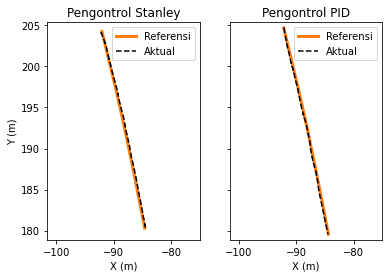

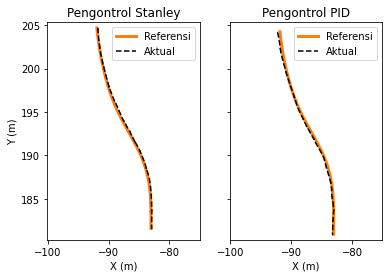

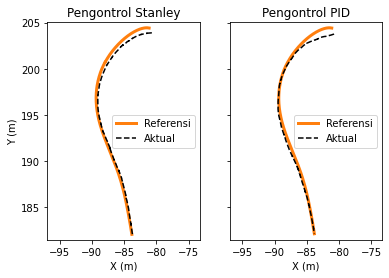

In [12]:
plot_posisi(sl2, pl2, 'posisi_lurus')
plot_posisi(ss1, ps2, 'posisi_s')
plot_posisi(sb2, pb1, 'posisi_belok')

### Error Lateral

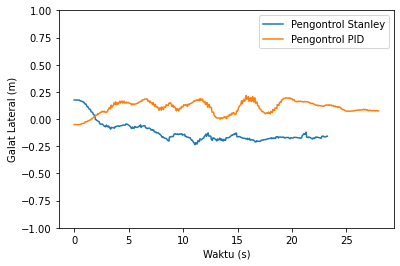

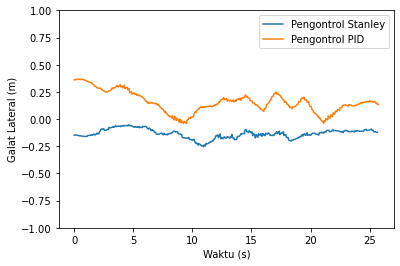

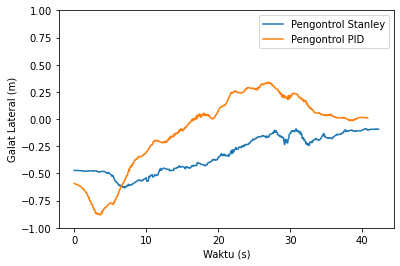

In [13]:
lim = [-1., 1.]
plot_e_lat(sl2, pl2, 'error_lateral_lurus', lim)
plot_e_lat(ss1, ps2, 'error_lateral_s', lim)
plot_e_lat(sb2, pb1, 'error_lateral_belok', lim)

### Error Yaw

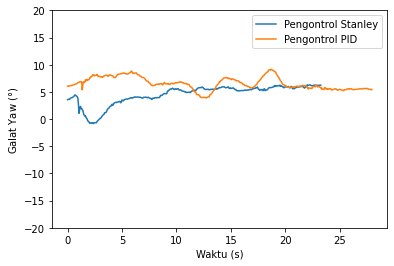

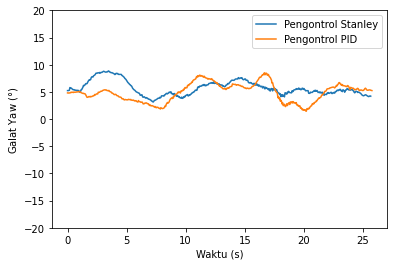

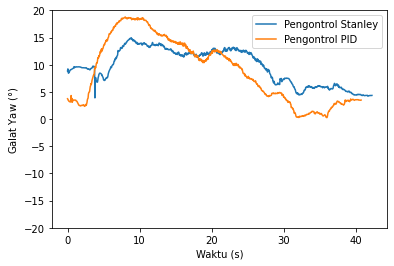

In [14]:
lim = [-20., 20.]
plot_e_yaw(sl2, pl2, 'error_yaw_lurus', lim)
plot_e_yaw(ss1, ps2, 'error_yaw_s', lim)
plot_e_yaw(sb2, pb1, 'error_yaw_belok', lim)

### Throttle

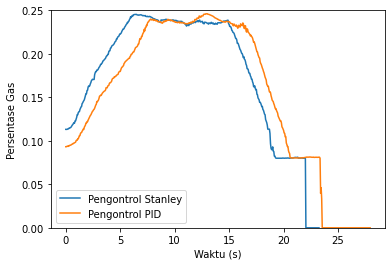

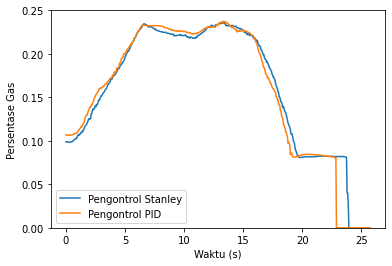

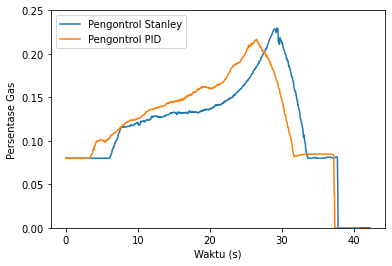

In [15]:
lim = [0., .25]
plot_throttle(sl2, pl2, 'throttle_lurus', lim)
plot_throttle(ss1, ps2, 'throttle_s', lim)
plot_throttle(sb2, pb1, 'throttle_belok', lim)

### Setir

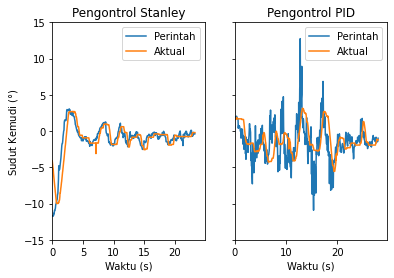

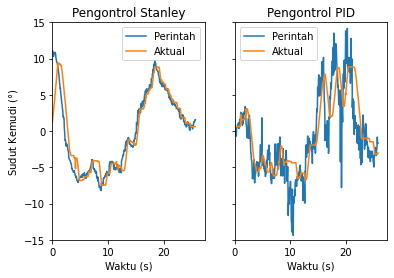

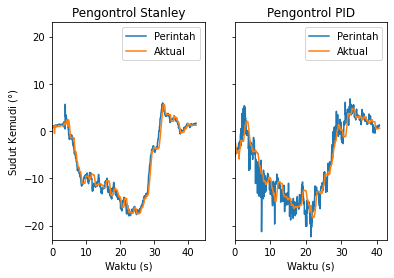

In [16]:
plot_steer(sl2, pl2, 'steer_lurus', [-15., 15.], 1.5)
plot_steer(ss1, ps2, 'steer_s', [-15., 15.], 1.5)
plot_steer(sb2, pb1, 'steer_belok', [-23., 23.], 1.5)

## Error Besar

### Function

In [17]:
def plot_posisi_v2(o1, fig_name):
    prx = o1.cs.ref_x
    pry = o1.cs.ref_y
    px = o1.cs.actual_x
    py = o1.cs.actual_y

    a = np.min(np.array([px, py]).T, axis=0)
    b = np.min(np.array([prx, pry]).T, axis=0)
    min_val = np.min(np.array([a,b]), axis=0)

    a = np.max(np.array([px, py]).T, axis=0)
    b = np.max(np.array([prx, pry]).T, axis=0)
    max_val = np.max(np.array([a,b]), axis=0)

    center = (max_val + min_val) / 2
    scale = max_val - min_val
    max_scale = np.max(scale)

    lim_min = center - max_scale/1.9
    lim_max = center + max_scale/1.9

    plt.plot(prx, pry, label='Referensi', linewidth=3., color='tab:orange')
    plt.plot(px, py, label='Aktual', linestyle='--', linewidth=2.5, color='tab:blue')
    plt.xlim(lim_min[0], lim_max[0])
    plt.ylim(lim_min[1], lim_max[1])
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.legend()

    plt.savefig('img/'+fig_name+'.png', dpi=600, transparent=True)
    plt.show()

def plot_e_lat_v2(o1, fig_name, lim):
    plt.plot(o1.cs.t - o1.cs.t[0], o1.cs.error_lateral, label='Aktual', linewidth=2.)
    plt.xlabel("Waktu (s)")
    plt.ylabel("Galat Lateral (m)")
#     plt.legend()
    plt.ylim(min(lim), max(lim))
    plt.savefig('img/'+fig_name+'.png', dpi=600, transparent=True)
    plt.show()
    
def plot_e_yaw_v2(o1, fig_name, lim):
    plt.plot(o1.cs.t - o1.cs.t[0], o1.cs.error_yaw*180./np.pi, label='Aktual')
    plt.xlabel("Waktu (s)")
    plt.ylabel(r"Galat Yaw $(\degree)$")
#     plt.legend()
    plt.ylim(min(lim), max(lim))
    plt.savefig('img/'+fig_name+'.png', dpi=600, transparent=True)
    plt.show()
    
def plot_throttle_v2(o1, fig_name, lim):
    plt.plot(o1.cs.t - o1.cs.t[0], o1.cs.action_throttle, label='Gas')
    plt.xlabel("Waktu (s)")
    plt.ylabel("Persentase Gas")
#     plt.legend()
    plt.ylim(min(lim), max(lim))
    plt.savefig('img/'+fig_name+'.png', dpi=600, transparent=True)
    plt.show()
    
def plot_steer_v2(o1, fig_name, lim, lim_fil):
    for i in range(1, o1.ar.t.shape[0]):
        if np.abs(o1.ar.steering_angle[i] - o1.ar.steering_angle[i-1]) >= lim_fil:
            o1.ar.steering_angle[i] = o1.ar.steering_angle[i-1]
    
    plt.plot(o1.cs.t - o1.cs.t[0], o1.cs.action_steer, label='Perintah')
    plt.plot(o1.ar.t - o1.cs.t[0], o1.ar.steering_angle, label='Aktual')
    plt.ylim(min(lim), max(lim))
    plt.xlim(0., None)
    plt.xlabel("Waktu (s)")
    plt.ylabel(r"Sudut Kemudi $(\degree)$")
    plt.legend()
    
    plt.savefig('img/'+fig_name+'.png', dpi=600, transparent=True)
    plt.show()

### LURUS

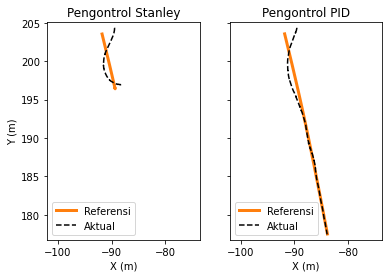

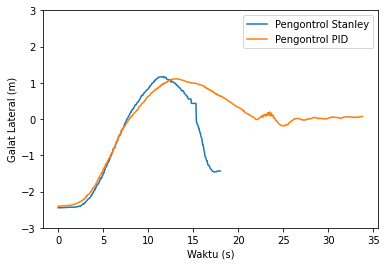

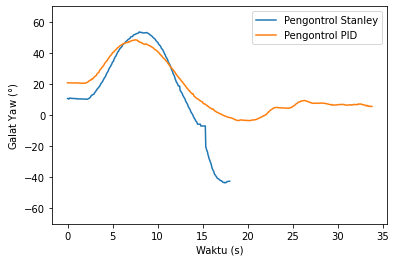

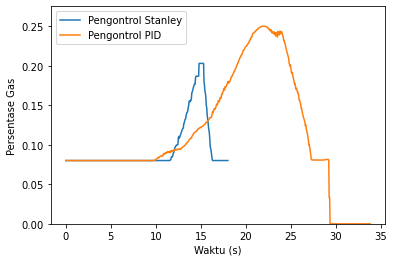

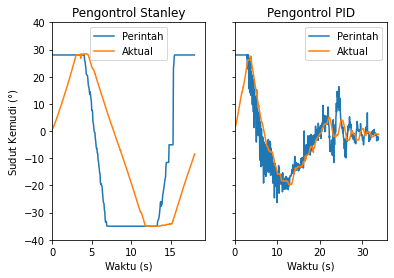

In [18]:
plot_posisi(sl3, pl3, 'e_besar_lurus_posisi')
plot_e_lat(sl3, pl3, 'e_besar_lurus_error_lateral', [-3., 3.])
plot_e_yaw(sl3, pl3, 'e_besar_lurus_error_yaw', [-70., 70.])
plot_throttle(sl3, pl3, 'e_besar_lurus_throttle', [0., 0.275])
plot_steer(sl3, pl3, 'e_besar_lurus_steer', [-40., 40.], 2.)

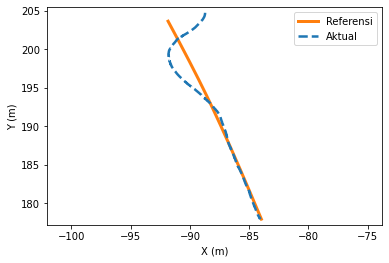

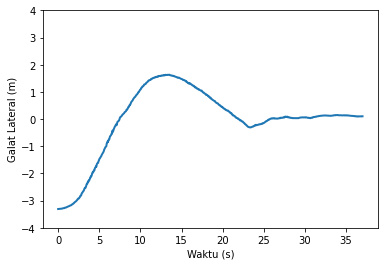

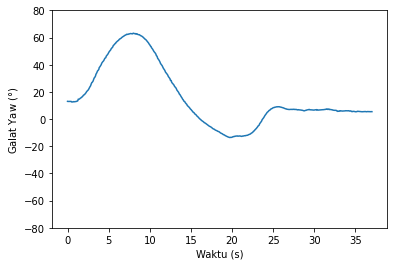

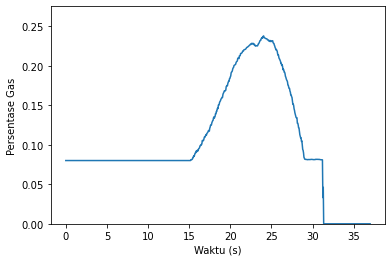

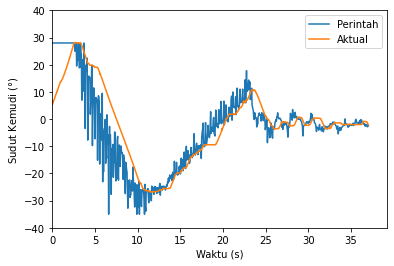

In [19]:
plot_posisi_v2(pl4, 'e_besar_lurus_4_posisi')
plot_e_lat_v2(pl4, 'e_besar_lurus_4_e_lat', [-4., 4.])
plot_e_yaw_v2(pl4, 'e_besar_lurus_4_e_yaw', [-80., 80.])
plot_throttle_v2(pl4, 'e_besar_lurus_4_throttle', [0., 0.275])
plot_steer_v2(pl4, 'e_besar_lurus_4_steer', [-40., 40.], 2.)

### S

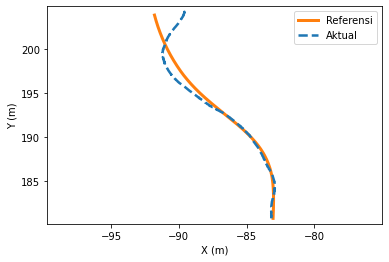

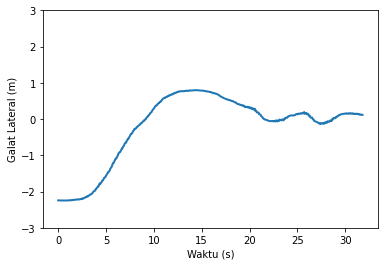

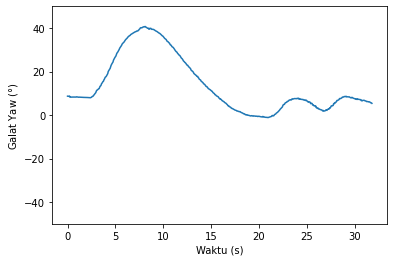

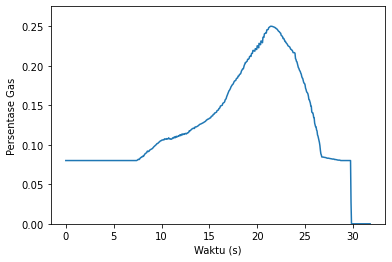

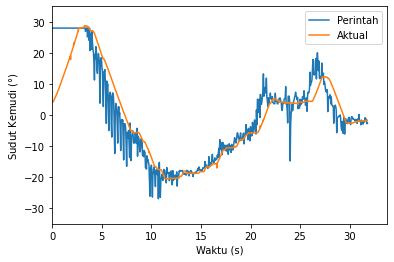

In [20]:
plot_posisi_v2(ps3, 'e_besar_s_posisi')
plot_e_lat_v2(ps3, 'e_besar_s_e_lat', [-3., 3.])
plot_e_yaw_v2(ps3, 'e_besar_s_e_yaw', [-50., 50.])
plot_throttle_v2(ps3, 'e_besar_s_throttle', [0., 0.275])
plot_steer_v2(ps3, 'e_besar_s_steer', [-35., 35.], 2.)